# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:

# Load pickled data
import pickle


training_file = './train.p'
validation_file= './valid.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

## Step 1: Dataset Summary & Exploration

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import pandas as pd

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: Number of validating examples.
n_valid = len(X_valid)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(pd.value_counts(y_train))
 

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Data exploration visualization code

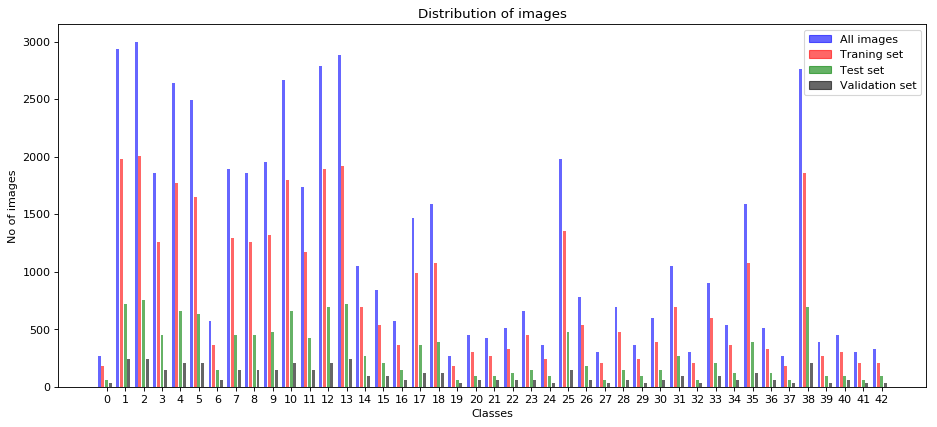

In [3]:

import matplotlib.pyplot as plt
import random
import numpy as np
import cv2
import matplotlib.patches as mpatches
# Visualizations will be shown in the notebook.
%matplotlib inline
fig=plt.figure(figsize=(14, 6), dpi= 80, facecolor='w', edgecolor='k')
combined = np.concatenate([y_train , y_test , y_valid])
all_data = np.unique(combined,return_counts=True)
training_data = np.unique(y_train,return_counts=True)
testing_data = np.unique(y_test,return_counts=True)
validation_data = np.unique(y_valid,return_counts=True)
lable_name = all_data[0]
lable_count = all_data[1]
y_pos = np.arange(len(lable_name))
y_pos = np.multiply(y_pos,5)
y_pos_train = np.add(y_pos,1)
y_pos_valid = np.add(y_pos,3)
y_pos_test = np.add(y_pos,2)
plt.bar(y_pos,lable_count, align='center',color='Blue', alpha=0.6)
plt.bar(y_pos_train,training_data[1], align='center',color='Red', alpha=0.6)
plt.bar(y_pos_test,testing_data[1], align='center',color='Green', alpha=0.6)
plt.bar(y_pos_valid,validation_data[1], align='center',color='Black', alpha=0.6)
plt.xticks(np.add(y_pos,2), lable_name)
plt.ylabel('No of images')
plt.xlabel('Classes')
plt.title('Distribution of images')


blue_patch = mpatches.Patch(color='Blue',alpha=0.6, label='All images')
red_patch = mpatches.Patch(color='Red',alpha=0.6, label='Traning set')
green_patch = mpatches.Patch(color='Green',alpha=0.6, label='Test set')
purple_patch = mpatches.Patch(color='black',alpha=0.6, label='Validation set')
plt.legend(handles=[blue_patch,red_patch,green_patch,purple_patch])
plt.show()

Speed limit (20km/h)


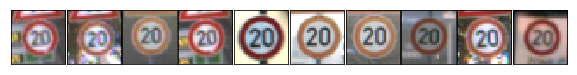

Speed limit (30km/h)


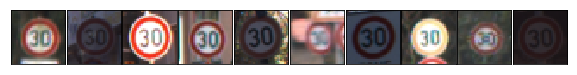

Speed limit (50km/h)


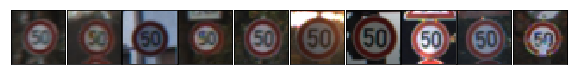

In [4]:


%matplotlib inline

# This Function returns the Name of the traffic sign whos class id is passed to it

def plot_sign(sign_value):
    Class_names = pd.read_csv('./signnames.csv').values
    for classid in Class_names:
        if classid[0] == sign_value:
            return classid[1]

# Display a Row of images        
def display_class(sign_value,y,X,cmap=None,rand_images=None):
    fig = plt.figure(figsize = (10, 1)) 
    fig.subplots_adjust(hspace = 0, wspace = 0)
    if rand_images == None:
        indices = np.where(y==sign_value)[0]
        rand_images = random.sample(list(indices), 10)
        
    for i in range(10):
        disp = fig.add_subplot(1,10, i+1, xticks=[], yticks=[])
        if cmap == None:
            disp.imshow(X[rand_images[i]])
        else: 
            disp.imshow(X[rand_images[i]].squeeze(), cmap=cmap)
    plt.show()
    return rand_images
        
for i in range(3):
    print(plot_sign(i))
    display_class(i,y_train,X_train,cmap=None)  

## Step 2: Design and Test a Model Architecture


### Pre-process the Data Set (normalization, grayscale, etc.)

In [5]:
# converts to grayscale
# Adds contrast to the image using CLAHE (Contrast Limited Adaptive Histogram Equalization) 
def grayIt(img):
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    cl1 = clahe.apply(lab)
    return np.resize(cl1, (32,32,1))

# value range -0.5 to 0.5
def normalizeIt(img):
    return .5+ img/255.00

# Applies the above two functions
def preprocessIt(img):    
    return normalizeIt(grayIt(img))

# Keep the old images for the Visualization comparing preprocessed images with raw image.
X_train_old = X_train

X_train = [preprocessIt(X) for X in X_train]
X_valid = [preprocessIt(X) for X in X_valid]
X_test  = [preprocessIt(X) for X in X_test]



Before vs After Preprocessing  Speed limit (20km/h)


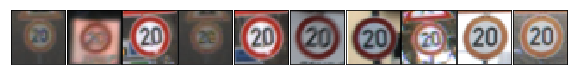

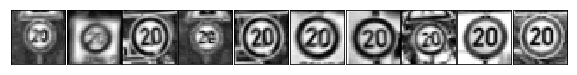

Before vs After Preprocessing  Speed limit (30km/h)


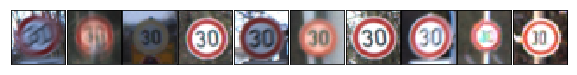

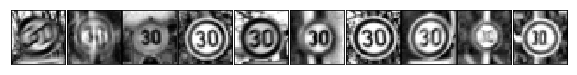

Before vs After Preprocessing  Speed limit (50km/h)


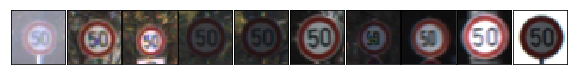

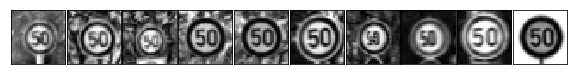

Before vs After Preprocessing  Speed limit (60km/h)


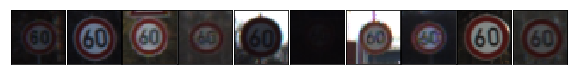

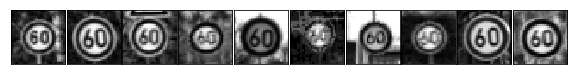

Before vs After Preprocessing  Speed limit (70km/h)


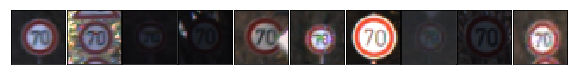

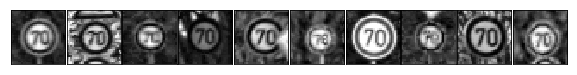

In [6]:
for i in range(5):
    print('Before vs After Preprocessing ',plot_sign(i))
    indices = display_class(i,y_train,X_train_old,cmap=None)
    display_class(i,y_train,X_train,cmap='gray',rand_images=indices)

### Model Architecture

In [7]:
import os
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

def SimpleNet(x):
    
    mu = 0
    sigma = 0.1
    
    #Layer 1
    # Convolutional Layer.
    # Input = 32x32x1.
    # Output = 26x26x30.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(7, 7, 1,30), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros([30]))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    
    #Layer 2
    # Max Pooling.
    # Input = 26x26x30. 
    # Output = 13x13x30
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    
    #Layer 3
    # Convolutional Layer.
    # Input  = 13x13x30
    # Output = 9x9x60.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 30, 60), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros([60]))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    
    #Layer 4
    # Max Pooling. 
    # Input = 9x9x60. 
    # Output = 4x4x60.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    #Layer 5
    # Flatten. 
    # Input = 4x4x60.
    # Output = 960.
    fc1 = flatten(conv2)
    
    # Dropout.
    # Keep_prob = 70%.
    fc1 = tf.nn.dropout(fc1, 0.7)
    
    #layer 6
    # Fully Connected. 
    # Input = 960. 
    # Output = 43.
    fc3_W = tf.Variable(tf.truncated_normal(shape=(960, 43), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros([43]))
    logits = tf.nn.xw_plus_b(fc1, fc3_W, fc3_b)
    
    return logits

In [8]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
y_one_hot = tf.one_hot(y, n_classes)
logits = SimpleNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, y_one_hot)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
training_operation = optimizer.minimize(loss_operation)

In [9]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_one_hot, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

# Using a Larger Batch Size as memory is available 
EPOCHS = 70
BATCH_SIZE = 512

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

In [10]:

# Train the model

valid_acc = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    for i in range(EPOCHS):
        print("EPOCH =  {} ".format(i+1), end='')
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        validation_accuracy = evaluate(X_valid, y_valid)
        traning_accuracy = evaluate(X_train, y_train)
        print("  || Validation Accuracy = {:.3f}".format(validation_accuracy),end='')
        print(" || Test Accuracy = {:.3f}".format(traning_accuracy),end='')
        if valid_acc < validation_accuracy:
            improvement = validation_accuracy - valid_acc
            valid_acc = validation_accuracy
            print(" || Accuracy improvement = {:.3f}% ".format((improvement/valid_acc)*100),end='')
            saver.save(sess, './lenet')
            print(" || Model Saved.")
        else:
            print ('|| No improvement in Accuracy || Model Not Saved.')
print('Final Validation accuracy = {:.3f} '.format(valid_acc))
    

Training...
EPOCH =  1   || Validation Accuracy = 0.349 || Test Accuracy = 0.400 || Accuracy improvement = 100.000%  || Model Saved.
EPOCH =  2   || Validation Accuracy = 0.618 || Test Accuracy = 0.658 || Accuracy improvement = 43.470%  || Model Saved.
EPOCH =  3   || Validation Accuracy = 0.740 || Test Accuracy = 0.769 || Accuracy improvement = 16.457%  || Model Saved.
EPOCH =  4   || Validation Accuracy = 0.787 || Test Accuracy = 0.829 || Accuracy improvement = 5.993%  || Model Saved.
EPOCH =  5   || Validation Accuracy = 0.821 || Test Accuracy = 0.865 || Accuracy improvement = 4.090%  || Model Saved.
EPOCH =  6   || Validation Accuracy = 0.847 || Test Accuracy = 0.887 || Accuracy improvement = 3.080%  || Model Saved.
EPOCH =  7   || Validation Accuracy = 0.859 || Test Accuracy = 0.904 || Accuracy improvement = 1.400%  || Model Saved.
EPOCH =  8   || Validation Accuracy = 0.884 || Test Accuracy = 0.920 || Accuracy improvement = 2.873%  || Model Saved.
EPOCH =  9   || Validation Accur

In [11]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.944


## Step 3: Test a Model on New Images

### Load and Output the Images

Web images before and after preprocessing


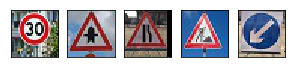

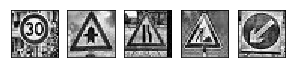

In [12]:
import matplotlib.image as mpimg

img = mpimg.imread('./web_images/1.jpg')
X_web =[img]
img = mpimg.imread('./web_images/11.jpg')
X_web.append(img)
img = mpimg.imread('./web_images/24.jpg')
X_web.append(img)
img = mpimg.imread('./web_images/25.jpg')
X_web.append(img)
img = mpimg.imread('./web_images/39.jpg')
X_web.append(img)
y_web = [1,11,24,25,39]
fig = plt.figure(figsize = (10, 1))

print('Web images before and after preprocessing')
for i in range(5):
    disp = fig.add_subplot(1,10, i+1, xticks=[], yticks=[])
    disp.imshow(X_web[i])
    
fig = plt.figure(figsize = (10, 1))
X_web_pp =  [preprocessIt(X) for X in X_web]
for i in range(5):
    disp = fig.add_subplot(1,10, i+1, xticks=[], yticks=[])
    disp.imshow(X_web_pp[i].squeeze(), cmap='gray' )    
plt.show() 
    


### Analyze Performance

In [13]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    web_accuracy = evaluate(X_web_pp, y_web)
    print("Accuracy on web images = {:.3f}".format(web_accuracy))

Accuracy on web images = 0.800


### Predict the Sign Type for Each Image

In [14]:
probs=[]
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    for img_no in range(len(y_web)):
        big=y_web[img_no]
        probs.append(sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), feed_dict={x:[X_web_pp[img_no]]}))

    


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

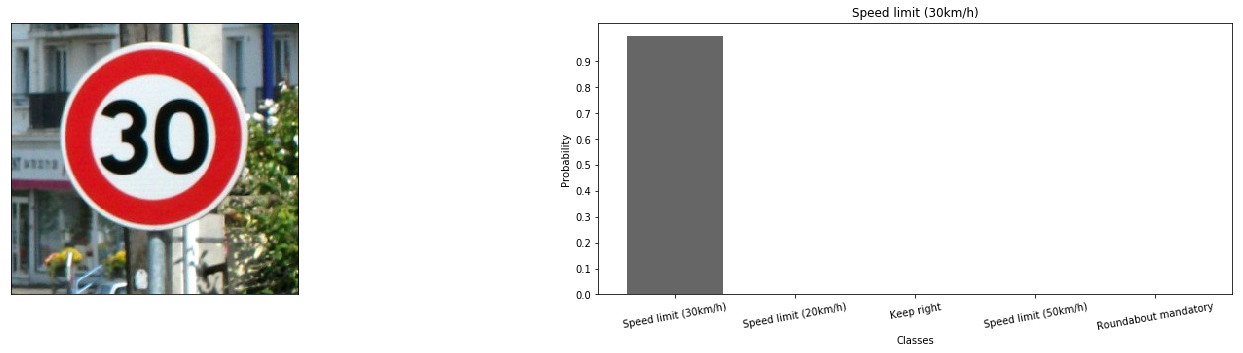

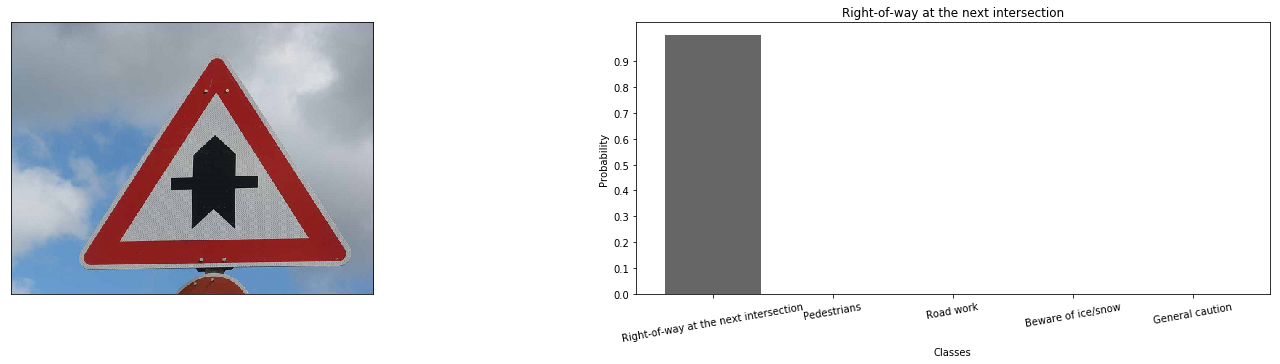

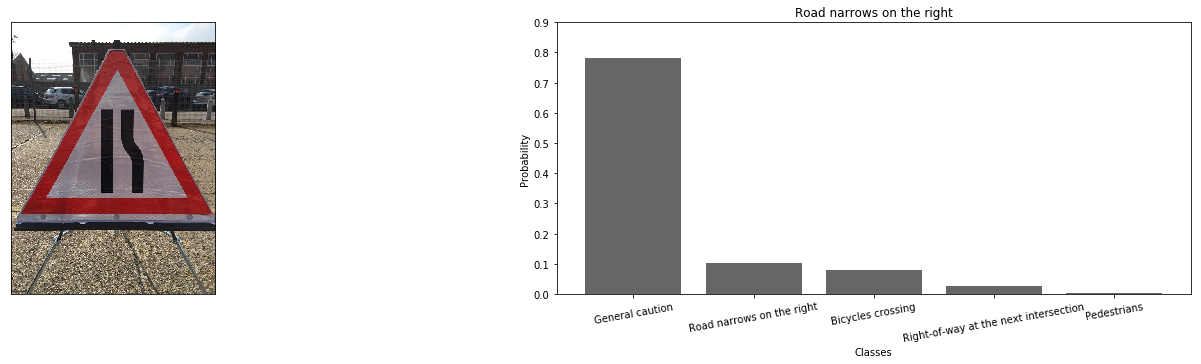

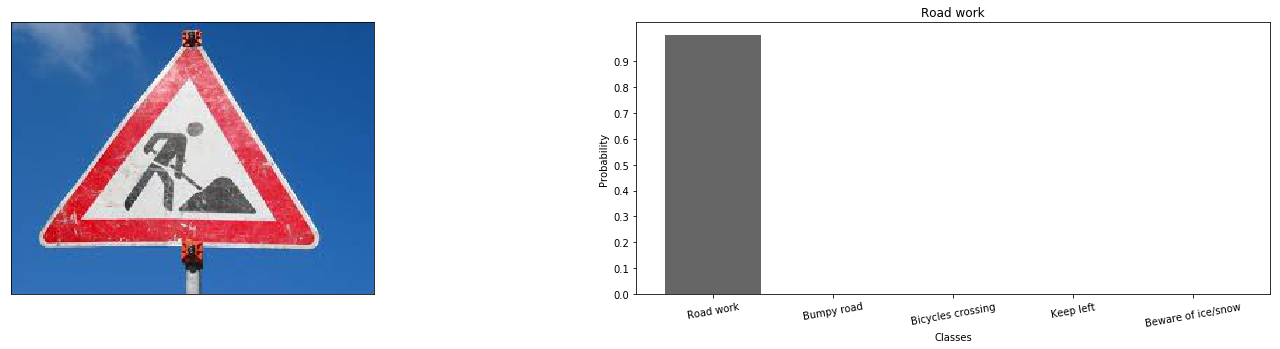

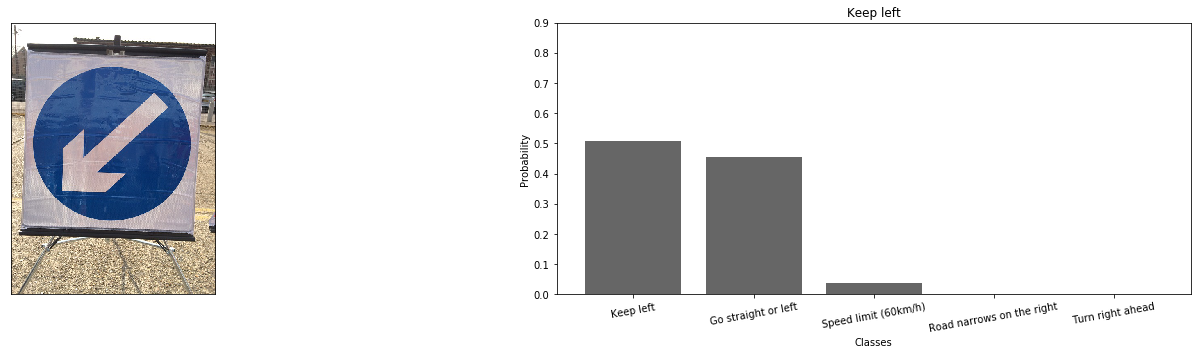

In [15]:
for image_no in range(5):
    fig = plt.figure(figsize = (25,5))
    img_big = mpimg.imread('./web_images/'+str(y_web[image_no])+'_big.jpg')
    disp = fig.add_subplot(1,2,1, xticks=[], yticks=[])
    disp.imshow(img_big)
    disp = fig.add_subplot(1,2,2, xticks=[], yticks=[])
    plt.bar(range(5),probs[image_no].values[0], align='center',color='Black', alpha=0.6, )
    plt.xticks(np.array(range(0,5)),[plot_sign(x) for x in probs[image_no].indices[0]],rotation=10)
    plt.yticks(np.arange(0,1,0.1))
    plt.ylabel('Probability')
    plt.xlabel('Classes')
    plt.title(plot_sign(y_web[image_no]))
    plt.show()